Sorry it's in Japanese.

当Codeは、[リンクアンドモチベーション Advent Calendar 2024](https://qiita.com/advent-calendar/2024/lmi) の記事として作成しました。

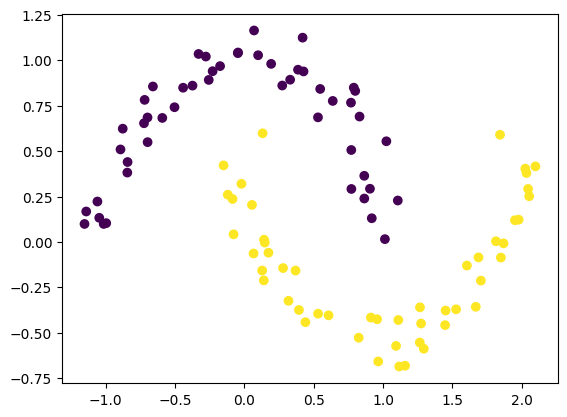

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## はじめに

本文章では、2次元上で非線形分類できないデータセットに対し、カーネルSVMの基本的な考え方である**高次元へ射影して線形分離できるようにする**といった内容を可視化し、理解を深めることを目的とします。データセットとしては、[Social_Network_Ads](https://www.kaggle.com/datasets/amisha0528/social-network-ads) を使用させていただきます🙏

できる限り、基本的な部分に対する解説もつけようと思っています。

- [ ] データ分析入門で該当箇所を読み、追記を行なっていく。

## 1. 準備

諸々準備をします。よく使われるライブラリはインポートしておきます。

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/social-network-ads-csv/Social_Network_Ads.csv


In [4]:
data = pd.read_csv('/kaggle/input/social-network-ads-csv/Social_Network_Ads.csv')

## 2. データの概要

データの確認をします。

これをするのは、データを正しく理解し、問題に適した前処理やモデル選択を行うためです。

データとしては非常に単純で、Age（年齢）、EstimatedSalary（推定給与）、Purchased（購入有無）となります。
また欠損地はなく、データは全て数値データです。

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


上記からわかっているが、欠損値の確認。

In [6]:
print(data.isnull().sum())

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64


In [7]:
print(data.head())

   Age  EstimatedSalary  Purchased
0   19            19000          0
1   35            20000          0
2   26            43000          0
3   27            57000          0
4   19            76000          0


統計情報を確認します。

分布などを確認、外れ値の存在を推測します。重要そうな特徴量はどれかを考えます。といっても、今回は3カラムだけではありますが。

データ数は400あり、年齢は18歳から60歳まで。推定給与は15000から150000ということがわかります（単位はドル？）。

In [8]:
print(data.describe())

              Age  EstimatedSalary   Purchased
count  400.000000       400.000000  400.000000
mean    37.655000     69742.500000    0.357500
std     10.482877     34096.960282    0.479864
min     18.000000     15000.000000    0.000000
25%     29.750000     43000.000000    0.000000
50%     37.000000     70000.000000    0.000000
75%     46.000000     88000.000000    1.000000
max     60.000000    150000.000000    1.000000


## 3. データの詳細

各カラムに対するデータの中身を確認していきます

Ageの分布を見ます

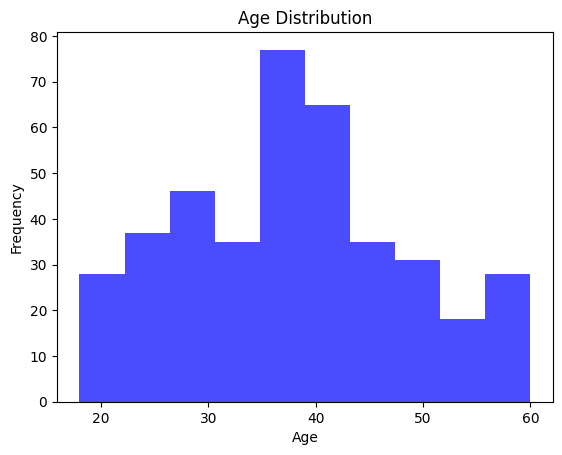

In [9]:
plt.hist(data['Age'], bins=10, alpha=0.7, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

同様に、EstimatedSalaryの分布はこちら

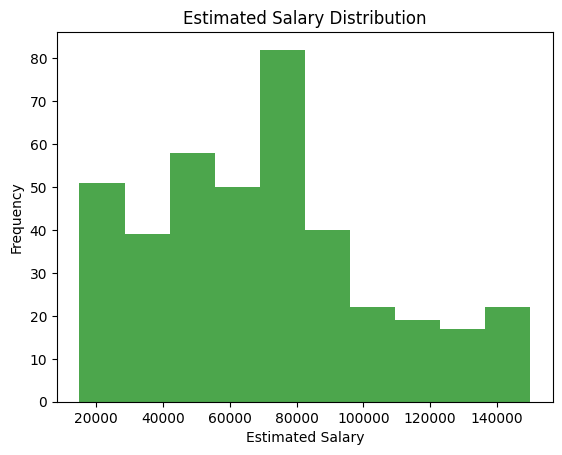

In [10]:
plt.hist(data['EstimatedSalary'], bins=10, alpha=0.7, color='green')
plt.title('Estimated Salary Distribution')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')
plt.show()

Purchased について、半数以上は買っていない。

In [11]:
print(data['Purchased'].value_counts())

Purchased
0    257
1    143
Name: count, dtype: int64


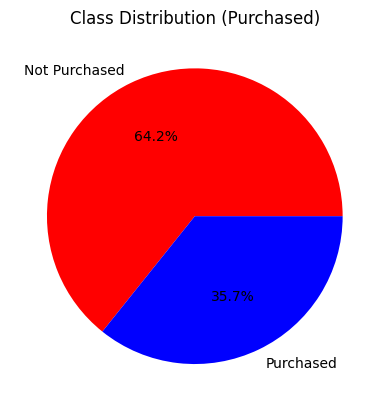

In [12]:
data['Purchased'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['red', 'blue'], labels=['Not Purchased', 'Purchased'])
plt.title('Class Distribution (Purchased)')
plt.ylabel('')
plt.show()

データを2次元の散布図としてプロットし、各点をラベルに応じて色分けする。

この感じだと、線形に分離することは難しそう。

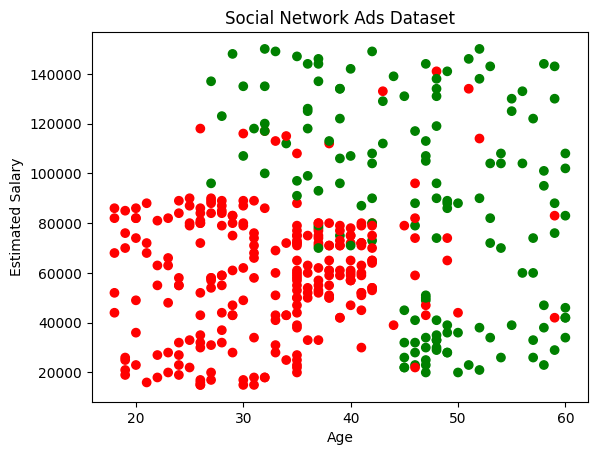

In [13]:
from matplotlib.colors import ListedColormap

# 必要な列を抽出
X = data[['Age', 'EstimatedSalary']].values
y = data['Purchased'].values

# データセットをプロット
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(('red', 'green')))
plt.title('Social Network Ads Dataset')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.show()

## 4. 標準化とモデルの学習

標準化する

データを平均0、標準偏差1の分布に変換する

In [14]:
from sklearn.preprocessing import StandardScaler

X = data[['Age', 'EstimatedSalary']]
y = data['Purchased']

# スケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
from sklearn.model_selection import train_test_split

# データをトレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.svm import SVC

# RBFカーネルを使用したSVMモデル
model = SVC(kernel='rbf', gamma=0.1, C=1.0, random_state=42)
model.fit(X_train, y_train)

SVC(gamma=0.1, random_state=42)

## 5. 予測

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)

# 混同行列と評価指標
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[48  4]
 [ 2 26]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        52
           1       0.87      0.93      0.90        28

    accuracy                           0.93        80
   macro avg       0.91      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80



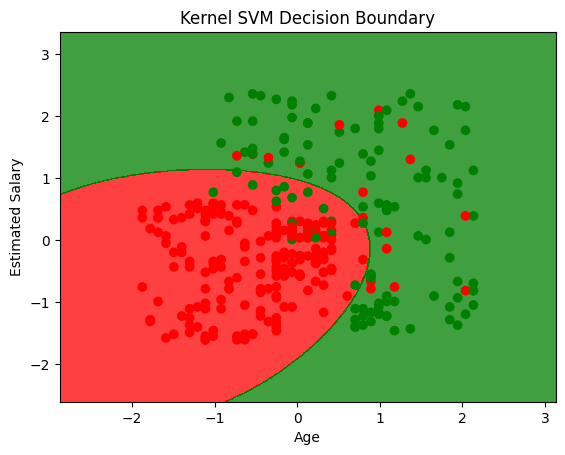

In [18]:
def plot_decision_boundary(X, y, model):
    X1, X2 = np.meshgrid(
        np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.01),
        np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.01)
    )
    plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha=0.75, cmap=ListedColormap(('red', 'green')))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(('red', 'green')))
    plt.title('Kernel SVM Decision Boundary')
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')
    plt.show()

# トレーニングデータでプロット
plot_decision_boundary(X_train, y_train, model)

## 6. 3次元への射影

力特徴量（Age と EstimatedSalary）に基づいて新しい非線形特徴を追加することで、データを高次元（3次元）空間に射影しています。

これにより、元の2次元平面では線形分離が難しいデータも、高次元空間で線形分離可能になることを直感的に理解することが目的です。

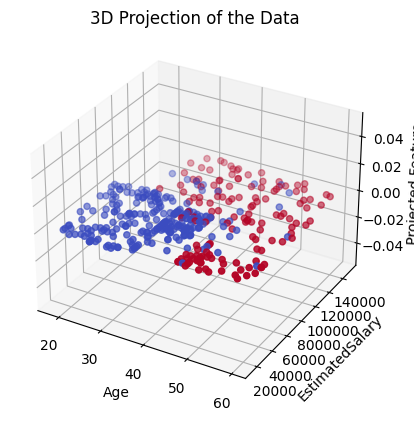

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# RBFカーネルを模した新しい特徴量
def rbf_projection(X, gamma=0.1):
    # 新しい特徴量: 距離から基づいたRBF変換
    return np.exp(-gamma * np.linalg.norm(X, axis=1)**2)

# 3次元に射影 (Age, EstimatedSalary, RBF変換後の特徴量)
X_projected = np.hstack((X, rbf_projection(X).reshape(-1, 1)))

# 3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=y, cmap=plt.cm.coolwarm)
ax.set_xlabel('Age')
ax.set_ylabel('EstimatedSalary')
ax.set_zlabel('Projected Feature')
plt.title('3D Projection of the Data')
plt.show()

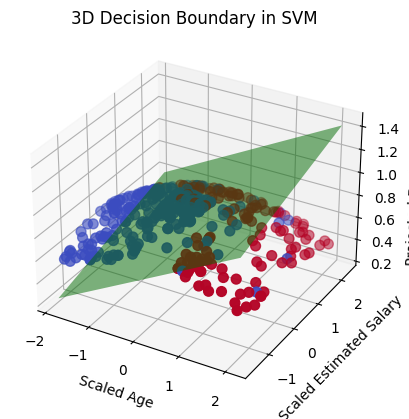

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# 特徴量とラベルを定義
X = data[['Age', 'EstimatedSalary']].values
y = data['Purchased'].values

# 特徴量をスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3次元目の特徴量を作成（RBFカーネルを模倣）
def rbf_projection(X, gamma=0.1):
    return np.exp(-gamma * np.linalg.norm(X, axis=1)**2)

Z = rbf_projection(X_scaled).reshape(-1, 1)
X_projected = np.hstack((X_scaled, Z))

# 3次元データに基づくSVMモデルの構築
model = SVC(kernel='linear')  # 線形カーネルで3次元平面を学習
model.fit(X_projected, y)

# 3次元プロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# データポイントをプロット
ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=y, cmap=plt.cm.coolwarm, s=50)

# グリッドポイントを作成して決定境界をプロット
xx, yy = np.meshgrid(np.linspace(X_projected[:, 0].min(), X_projected[:, 0].max(), 30),
                     np.linspace(X_projected[:, 1].min(), X_projected[:, 1].max(), 30))
zz = (-model.coef_[0, 0] * xx - model.coef_[0, 1] * yy - model.intercept_[0]) / model.coef_[0, 2]
ax.plot_surface(xx, yy, zz, alpha=0.5, rstride=100, cstride=100, color='green')

# 軸ラベルの設定
ax.set_xlabel('Scaled Age')
ax.set_ylabel('Scaled Estimated Salary')
ax.set_zlabel('Projected Feature (RBF)')
plt.title('3D Decision Boundary in SVM')
plt.show()

参考

- [Social_Network_Ads](https://www.kaggle.com/datasets/amisha0528/social-network-ads)
- [［第3版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践](https://book.impress.co.jp/books/1120101017)
- [ディープラーニングG検定（ジェネラリスト）最強の合格テキスト［第2版］](https://www.sbcr.jp/product/4815622756/)